In [41]:
import ROOT

In [42]:
import os

In [43]:
import numpy as np 

# Fake Rate method 

## Extract the number of "fakes" and subtract them from background in a statistical way

Involves determining a fake rate $f$ from a jet-enriched data control sample and applying it to the analysis dataset containing triphotons passing the final analysis selection.

To-do: 

Step 0: Prepare template making machinery prototype

* Make real templates 
* Make fake templates 
* Make denominator 
* Make numerator templates 

Step 1: Make the Templates and compare them

Step 2: Make the Fitting Code

Step 3: Fake Rate Derivation

Step 4: Reweighting

```
tchain = ROOT.TChain("demo/EventTree")
# For Real Templates
tchain.Add("nTuple_GGGJets_Pt-15_13TeV-sherpa_evt17800.root")

# For Closure Test 
tchain.Add("nTuple_GGJets_Pt-15_13TeV-sherpa_evt71999.root")
#tchain.Add("nTuple_QCD_Pt15to7000_TuneCP5_Flat2018_pythia8_evt78000.root") # maybe not include this in the templates
#-- FIXME: Also include 

# For Fake Rate 
# ---- Look at JetHT and Muon Samples 

print ('Total number of events: ' + str(tchain.GetEntries()))
```

# List of Cuts from Analyzer 

Taken from Real template maker [ExoDiphoton](https://github.com/uzzielperez/diphoton-analysis/blob/master/FakeRateAnalysis/RealTemplateAnalysis/analysis/MCFakeRateAnalysis.C)

`pho_sigmaIphiIphi5X5 < 0.0009` continue

`pho_r9_5x5 < 0.5` continue # r9 from resonant sync

### EtaBin cuts:

EB: $ |\eta| < 1.4442$

EE: $1.566 < |\eta|  < 2.5$

### Fine-tuning cuts

If necessary

EB1: $ \eta < 0.7221 $

EB2: $0.7221 < |\eta| < 1.4442$

EE1: $1.566 < |\eta| < 2.033$

EE2: $2.033 < |\eta| < 2.5$


## Numerator Cuts

To be considered as Numerator Object Candidate, these are the cuts:

`passID` We will go for tight 

H/E < 0.05

`corPhoIso < (double)0.2*photon->pt()` # What is this for?

`pho->passElectronVeto()`

`pho->full5x5_r9() > 0.8`

For Sieie_numerator object, must also pass CHIsoCut

`pho->chargedHadronIso() < 5`

For cHIso_numerator, must also pass sieiecut. It's a little more complicated: 

if EB and not saturated :   $ \sigma_{i\eta i\eta}   $ < 0.0105
if EB and saturated: $ \sigma_{i\eta i\eta}   $ < 0.0112
if EE and not saturated: $ \sigma_{i\eta i\eta}   $ < 0.0280
if EE and not saturated: $ \sigma_{i\eta i\eta}   $ < 0.0300

I probably don't care about the saturation part

## Rationale for the cuts (WIP) 

## Questions 

* Why couldn't this be reduced to a classification problem? (Checkout Andrew's project: https://github.com/abuccilli/photon-classification)

# Numerator templates

### The way we've done things before that worked

The number of jets passing the photon ID. Technically, this would be *contaminated* with real photons. We remove this contamination by a fitting procedure where the template models of real and fake photons are fit to the "numerator", i.e. the data in the control sample.

```
bool is_sieie_numerator_object = Photon_isNumeratorObjCand && Photon_passChIso;
bool is_chIso_numerator_object = Photon_isNumeratorObjCand && Photon_passSieie;
```

At least for the ExoDiphotonAnalyzer the isNumeratorObjCand is defined as: 

```
  bool passNumeratorCandCut(const pat::Photon* photon, double rho) {
    if (
      passHadTowerOverEmCut(photon) &&
      passCorPhoIsoHighPtID(photon,rho) &&
      photon->passElectronVeto() &&
      passR9Cut(photon)
    ) return true;

    else return false;
  }
 ```
 
 Basically the numerator selection is the photon ID except for the sieie/chisocut.

# Denominator Templates 

The number of jets passing a looser, photon-like ID. The denominator ID is chosen s.t. the two categories are orthogonal. This means that if we prepare a template on sieie, then it should pass the CHIso selection but not the sieie (?) and vice-versa. 


```
bool is_denominator_object = Photon_isDenominatorObj && Photon_hadronicOverEm < 0.1;
```

```
 bool passDenominatorCut(const pat::Photon* photon, double rho, bool isSat) {

    double phoEta = fabs( photon->superCluster()->eta() );
    bool isEB = phoEta < 1.4442;
    bool isEE = 1.566 < phoEta && phoEta < 2.5;
    
    // first check if the photon fails at least one of the high pT ID cuts
    bool failID = (
      !passHadTowerOverEmCut(photon) ||
      !passChargedHadronCut(photon) ||
      !passSigmaIetaIetaCut(photon,isSat) ||
      !passR9Cut(photon)
    );

    if (isEB)
      failID = failID || !passCorPhoIsoHighPtID(photon,rho);
    
    // now check if it pass the looser ID
    bool passLooseIso = passChargedHadronDenomCut(photon) && passCorPhoIsoDenom(photon,rho);
    
    // require object to pass CSEV
    bool passCSEV = photon->passElectronVeto();

    // require object to pass an additional reco::Photon::hadronicOverEm cut
    bool passHadOverEmCut = photon->hadronicOverEm() < 0.1;

    bool passCorIso = passCorPhoIsoHighPtID(photon,rho);
    
    bool retVal = false;
    if (isEB && failID && passLooseIso && passCSEV && passHadOverEmCut){
      retVal = true;
      // return true;
    }
    else if (isEE && failID && passLooseIso && passCSEV && passHadOverEmCut && passCorIso){
      retVal = true;
    }

    return retVal;
  }
  
}
```

# Photon ID 

Note that we will just be using the Egamma ID: 

https://twiki.cern.ch/twiki/bin/view/CMS/EgammaRunIIRecommendations?rev=9#Fall17v2_AN1

# PREPARING THE TEMPLATES 

# Numerator Templates

Let's do it for closure test samples first (QCD, GJets, GGJets) and then later on JetHT and DoubleMuon. Note that the analyzer I'm using set up the passID information like this:


```
   // VID decisions
    UShort_t tmpphoIDbit = 0;
   // https://twiki.cern.ch/twiki/bin/view/CMS/EgammaRunIIRecommendations?rev=9#Fall17v2_AN1
   // FIXME: put IDs in config file?
   bool isPassLoose  = iPho->photonID("cutBasedPhotonID-Fall17-94X-V2-loose");
   if (isPassLoose)  setbit(tmpphoIDbit, 0);
   bool isPassMedium = iPho->photonID("cutBasedPhotonID-Fall17-94X-V2-medium");
   if (isPassMedium) setbit(tmpphoIDbit, 1);
   bool isPassTight  = iPho->photonID("cutBasedPhotonID-Fall17-94X-V2-tight");
   if (isPassTight)  setbit(tmpphoIDbit, 2);
   bool isPassMVAv1wp80  = iPho->photonID("mvaPhoID-RunIIFall17-v2-wp80");
   if (isPassMVAv1wp80)  setbit(tmpphoIDbit, 3);
   bool isPassMVAv1wp90  = iPho->photonID("mvaPhoID-RunIIFall17-v2-wp90");
   if (isPassMVAv1wp90)  setbit(tmpphoIDbit, 4);
   phoIDbit_.push_back(tmpphoIDbit);
 ```


# CONTINUE HERE 
I'm still figuring out how to access the ID. Like this `event.phoIDbit[i]&2 == 2`? 

https://realpython.com/python-encodings-guide/

https://realpython.com/python-bitwise-operators/

August 30, 2021

I talked to Sebastian to understand a little about this. It's a bit odd that phoIDbit is char. In the original ggNtuplizer it's UShort_t which is what I expect it to be. So maybe it's a good chance to rerun the analyzer and fix that issue and as well as double check the 

There are some instructions here on how to access the information: https://github.com/cmkuo/ggAnalysis

```
for photons it is done the same way: it has 3 IDs
so 3 bits represent the decision
Representing that integer in 3 bits: b2 b1 b0
b0: Loose; b1: Medium; b2: Tight
To access the decision for
(a) Loose: phoIDbit[]>>0&1 ---> gives 0 or 1. if 0--> this phoID is failed. if 1--> this phoID is passed
(b) Medium: phoIDbit[]>>1&1
(c) Tight: phoIDbit[]>>2&1
```

An example is also found here: https://github.com/mbandrews/STEALTH/blob/9099e7189f936e8e3cfdf023ae8b578a10593867/skimPhoLoose_Data.py#L74 


In [71]:
tNumChain = ROOT.TChain("demo/EventTree")
# tNumChain.Add("nTuple_GGGJets_Pt-15_13TeV-sherpa_evt17800.root")
tNumChain.Add("nTuple_GGJets_Pt-15_13TeV-sherpa_evt71999.root")
tNumChain.Add("nTuple_QCD_Pt15to7000_TuneCP5_Flat2018_pythia8_evt78000.root") 
print ('Total number of events: ' + str(tNumChain.GetEntries()))

Total number of events: 149999


In [73]:
maxEvents = tNumChain.GetEntries()
#maxEvents = 10

fileOut = ROOT.TFile('numerator_templates.root', 'RECREATE')
nPhoLoose, nPhoMedium, nPhoTight = 0, 0, 0 

# Bins 
nbinsSieieEB = 50 # 200 for data, 50 for closure test 
nbinsSieieEE = 25 # 100 for data, 25 for closure test 
nbinsChIso = 50   # 100 for data?, 50 for closure test 


# Histograms 
hSieieEBnumTemp_pT50_70 = ROOT.TH1D( 'hSieieEBnumTemp_pT50_70', 'sieieEB', nbinsSieieEB, 0., 0.1 )
hSieieEBnumTemp_pT70_90 = ROOT.TH1D( 'hSieieEBnumTemp_pT70_90', 'sieieEB', nbinsSieieEB, 0., 0.1 )
hSieieEBnumTemp_pT90_110 = ROOT.TH1D( 'hSieieEBnumTemp_pT90_110', 'sieieEB', nbinsSieieEB, 0., 0.1 )

hSieieEBnumTemp_pT50_70.Sumw2()
hSieieEBnumTemp_pT70_90.Sumw2()
hSieieEBnumTemp_pT90_110.Sumw2()


for ievent, event in enumerate(tNumChain):
    if ievent > maxEvents and maxEvents != -1: break 
    if ievent % 10000 == 0: print ('Processing entry ' + str(ievent))
    
    for i in range(event.nPho):
        phoPt = event.phoEt[i]
        if (event.phoIDbit[i]>>0&1 != 1): # >>0:loose, >>1:medium, >>2:tight
            nPhoLoose = nPhoLoose+1 
        if (event.phoIDbit[i]>>1&1 != 1): 
            nPhoMedium = nPhoMedium+1
        if (event.phoIDbit[i]>>1&1 != 1): 
            nPhoTight = nPhoTight+1
            if (50 < phoPt < 70 ):
                hSieieEBnumTemp_pT50_70.Fill(event.phoSigmaIEtaIEtaFull5x5[i])
            if (70 < phoPt < 90 ):
                hSieieEBnumTemp_pT70_90.Fill(event.phoSigmaIEtaIEtaFull5x5[i])
            if (90 < phoPt < 110):
                hSieieEBnumTemp_pT90_110.Fill(event.phoSigmaIEtaIEtaFull5x5[i])
            
print('loose: %d, medium %d, tight %d' %(nPhoLoose, nPhoMedium, nPhoTight))

fileOut.Write()
fileOut.Close()
print ('DONE')

Processing entry 0
Processing entry 10000
Processing entry 20000
Processing entry 30000
Processing entry 40000
Processing entry 50000
Processing entry 60000
Processing entry 70000
Processing entry 80000
Processing entry 90000
Processing entry 100000
Processing entry 110000
Processing entry 120000
Processing entry 130000
Processing entry 140000
loose: 96796, medium 114199, tight 114199
DONE


# Real Templates 

Patterned from this [code](https://github.com/uzzielperez/diphoton-analysis/blob/master/FakeRateAnalysis/RealTemplateAnalysis/analysis/MCFakeRateAnalysis.C)

http://cds.cern.ch/record/2668304/files/CERN-THESIS-2018-380.pdf


First do intermediate step of filling histograms with these cuts:



In [12]:
def has_mcPho_match(event, pho_vec):
    min_delta_r = float('Inf')
    pid = 0 
    for mc in range(event.nMC):
        if event.mcPt[mc] > 1.0:
            mc_vec = ROOT.TLorentzVector()
            mc_vec.SetPtEtaPhiE(event.mcPt[mc], event.mcEta[mc], event.mcPhi[mc], event.mcE[mc])
            delta_r = pho_vec.DeltaR(mc_vec)
            if delta_r < min_delta_r: 
                min_delta_r = delta_r
                if delta_r < 0.3:
                    pid = abs(event.mcPID[mc])
    if pid == 22: return True 
    return False

In [74]:
tchain = ROOT.TChain("demo/EventTree")
tchain.Add("nTuple_GGGJets_Pt-15_13TeV-sherpa_evt17800.root")
print ('Total number of events: ' + str(tchain.GetEntries()))

outfile = 'real_templates.root'
# histname = "sieie%s_realTemp_pT%s-%s"%(etaBin, ) #EB or EE etaBin and #pT

Total number of events: 17800


To-do: Fill sample histograms and scale up. 

For the diphoton analysis, they used the following pT bins for the sidebands: 

`std::vector<int> ptBinArray({ 50, 70, 90, 110, 130, 150, 200, 250, 300, 600});`

We need to go to lower pT but for now we just want to look if the plots make sense.

In [76]:
maxEvents = tchain.GetEntries()

# Output file
fileOut = ROOT.TFile('real_templates.root', 'recreate')

# Bins 
nbinsSieieEB = 50 # 200 for data, 50 for closure test 
nbinsSieieEE = 25 # 100 for data, 25 for closure test 
nbinsChIso = 50   # 100 for data?, 50 for closure test 


# Histograms 
hSieieEBrealTemp_pT50_70 = ROOT.TH1D( 'hSieieEBrealTemp_pT50_70', 'sieieEB', nbinsSieieEB, 0., 0.1 )
hSieieEBrealTemp_pT70_90 = ROOT.TH1D( 'hSieieEBrealTemp_pT70_90', 'sieieEB', nbinsSieieEB, 0., 0.1 )
hSieieEBrealTemp_pT90_110 = ROOT.TH1D( 'hSieieEBrealTemp_pT90_110', 'sieieEB', nbinsSieieEB, 0., 0.1 )

hSieieEBrealTemp_pT50_70.Sumw2()
hSieieEBrealTemp_pT70_90.Sumw2()
hSieieEBrealTemp_pT90_110.Sumw2()

for ievent, event in enumerate(tchain):
    if ievent > maxEvents and maxEvents != -1: break 
    if ievent % 10000 == 0: print ('Processing entry ' + str(ievent))
        
    for i in range(event.nPho):
        if (event.phoEt[i] > 20.0 and event.phoIDbit[i]>>1&1 != 1):
            phoPt = event.phoEt[i]
            pho_vec = ROOT.TLorentzVector()
            pho_vec.SetPtEtaPhiE(event.phoEt[i], event.phoEta[i], event.phoPhi[i], event.phoE[i])
            if has_mcPho_match(event, pho_vec):
                if (50 < phoPt < 70 ):
                    hSieieEBrealTemp_pT50_70.Fill(event.phoSigmaIEtaIEtaFull5x5[i])
                if (70 < phoPt < 90 ):
                    hSieieEBrealTemp_pT70_90.Fill(event.phoSigmaIEtaIEtaFull5x5[i])
                if (90 < phoPt < 110):
                    hSieieEBrealTemp_pT90_110.Fill(event.phoSigmaIEtaIEtaFull5x5[i])
                    
                
fileOut.Write()
fileOut.Close()
print ('DONE')

Processing entry 0
Processing entry 10000
DONE


# Fake Templates (Closure Test) 

First, let's just call the fakes as those that don't match with a gen photon within a cone of $\Delta R < 0.3$

In [78]:
tchainCT = ROOT.TChain("demo/EventTree")
tchainCT.Add("nTuple_GGJets_Pt-15_13TeV-sherpa_evt71999.root")
#tchainCT.Add("nTuple_QCD_Pt15to7000_TuneCP5_Flat2018_pythia8_evt78000.root")

print ('Total number of events: ' + str(tchainCT.GetEntries()))

outfile = 'fakeCT_templates.root'

maxEvents = tchainCT.GetEntries()

# Output file
fileOut = ROOT.TFile('fakeCT_templates.root', 'recreate')

# Bins 
nbinsSieieEB = 50 # 200 for data, 50 for closure test 
nbinsSieieEE = 25 # 100 for data, 25 for closure test 
nbinsChIso = 50   # 100 for data?, 50 for closure test 

# Histograms 
hSieieEBfakeCTTemp_pT50_70 = ROOT.TH1D( 'hSieieEBfakeCTTemp_pT50_70', 'sieieEB', nbinsSieieEB, 0., 0.1 )
hSieieEBfakeCTTemp_pT70_90 = ROOT.TH1D( 'hSieieEBfakeCTTemp_pT70_90', 'sieieEB', nbinsSieieEB, 0., 0.1 )
hSieieEBfakeCTTemp_pT90_110 = ROOT.TH1D( 'hSieieEBfakeCTTemp_pT90_110', 'sieieEB', nbinsSieieEB, 0., 0.1 )

hSieieEBfakeCTTemp_pT50_70.Sumw2()
hSieieEBfakeCTTemp_pT70_90.Sumw2()
hSieieEBfakeCTTemp_pT90_110.Sumw2()

# There is a different loop for real, fakeCT, and fakeRate 
for ievent, event in enumerate(tchainCT):
    if ievent > maxEvents and maxEvents != -1: break 
    if ievent % 10000 == 0: print ('Processing entry ' + str(ievent))
        
    for i in range(event.nPho):
        if (event.phoEt[i] > 20.0 and event.phoIDbit[i]>>1&1 != 1):
            phoPt = event.phoEt[i]
            pho_vec = ROOT.TLorentzVector()
            pho_vec.SetPtEtaPhiE(event.phoEt[i], event.phoEta[i], event.phoPhi[i], event.phoE[i])
            if (has_mcPho_match(event, pho_vec)==False):
                if (50 < phoPt < 70 ):
                    hSieieEBfakeCTTemp_pT50_70.Fill(event.phoSigmaIEtaIEtaFull5x5[i])
                if (70 < phoPt < 90 ):
                    hSieieEBfakeCTTemp_pT70_90.Fill(event.phoSigmaIEtaIEtaFull5x5[i])
                if (90 < phoPt < 110):
                    hSieieEBfakeCTTemp_pT90_110.Fill(event.phoSigmaIEtaIEtaFull5x5[i])
                    
                
fileOut.Write()
fileOut.Close()
print ('DONE')

Total number of events: 71999
Processing entry 0
Processing entry 10000
Processing entry 20000
Processing entry 30000
Processing entry 40000
Processing entry 50000
Processing entry 60000
Processing entry 70000
DONE


# Templates Plots
Let's take a quick look at the templates we produced. As a reference, it should somehow look like these plots from Andrew's thesis. 

![FITS](imgs/numeratorfits.png)

Or for the newer fits: 

![Newer](imgs/numeratorfitsNew.png)

From my naive understanding, the numerator candidates are like data. It's like a superposition of the Fake and Real templates

## Numerator Templates

Our definition here is that anything that passes the "Tight" Photon ID (`cutBasedPhotonID-Fall17-94X-V2-tight`)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cNum


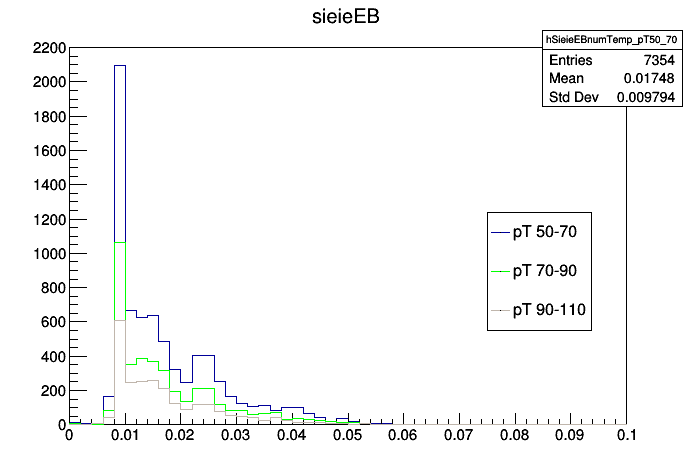

In [82]:
fNum = ROOT.TFile("numerator_templates.root", "READ") 

hNumTempSieiePT50_70  = fNum.Get("hSieieEBnumTemp_pT50_70")
hNumTempSieiePT70_90  = fNum.Get("hSieieEBnumTemp_pT70_90")
hNumTempSieiePT90_110 = fNum.Get("hSieieEBnumTemp_pT90_110")

cNum = ROOT.TCanvas("cNum")
cNum.cd()

hNumTempSieiePT50_70.Draw("HIST")
hNumTempSieiePT70_90.SetLineColor(3)
hNumTempSieiePT90_110.SetLineColor(11)
hNumTempSieiePT70_90.Draw("HIST, SAME")
hNumTempSieiePT90_110.Draw("HIST, SAME")

legend = ROOT.TLegend(0.7, 0.3, 0.85, 0.55)
legend.AddEntry(hNumTempSieiePT50_70, "pT 50-70")
legend.AddEntry(hNumTempSieiePT70_90, "pT 70-90")
legend.AddEntry(hNumTempSieiePT90_110, "pT 90-110")

legend.Draw("SAME")

cNum.Draw()

## Real Templates

* Passed Tight ID 
* Has Match to Real Gen Photon
* pT > 20 GeV

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cReal


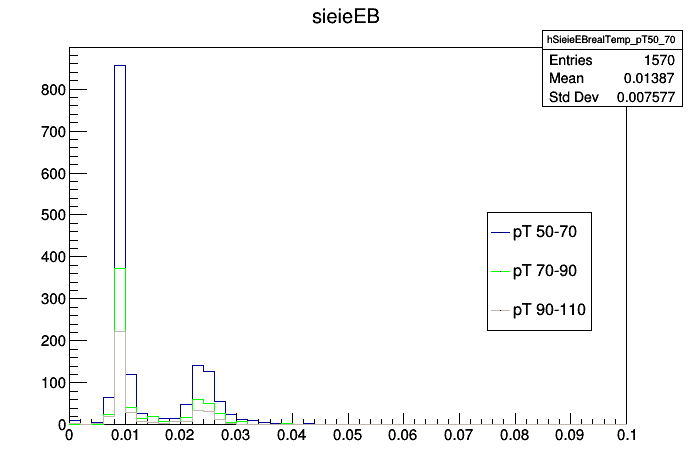

In [83]:
fReal = ROOT.TFile("real_templates.root", "READ")
fFake = ROOT.TFile("fakeCT_templates.root", "READ")

hRealTempSieiePT50_70 = fReal.Get("hSieieEBrealTemp_pT50_70")
hRealTempSieiePT70_90 = fReal.Get("hSieieEBrealTemp_pT70_90")
hRealTempSieiePT90_110 = fReal.Get("hSieieEBrealTemp_pT90_110")

cReal = ROOT.TCanvas("cReal")
cReal.cd()

hRealTempSieiePT50_70.Draw("HIST")
hRealTempSieiePT70_90.SetLineColor(3)
hRealTempSieiePT90_110.SetLineColor(11)
hRealTempSieiePT70_90.Draw("HIST, SAME")
hRealTempSieiePT90_110.Draw("HIST, SAME")

legend = ROOT.TLegend(0.7, 0.3, 0.85, 0.55)
legend.AddEntry(hRealTempSieiePT50_70, "pT 50-70")
legend.AddEntry(hRealTempSieiePT70_90, "pT 70-90")
legend.AddEntry(hRealTempSieiePT90_110, "pT 90-110")

legend.Draw("SAME")

cReal.Draw()

## Fake Closure Test Templates

* pass Tight Pho ID 
* Not Matched to GenPhoton within dr < 0.3
* pT > 20 GeV

In [ ]:
hFakeCTTempSieiePT50_70 = fFake.Get("hSieieEBfakeCTTemp_pT50_70")
hFakeCTTempSieiePT70_90 = fFake.Get("hSieieEBfakeCTTemp_pT70_90")
hFakeCTTempSieiePT90_110 = fFake.Get("hSieieEBfakeCTTemp_pT90_110")

cFake = ROOT.TCanvas("cFake")
cFake.cd()

hFakeCTTempSieiePT50_70.Draw("HIST")
hFakeCTTempSieiePT70_90.SetLineColor(3)
hFakeCTTempSieiePT90_110.SetLineColor(6)
hFakeCTTempSieiePT70_90.Draw("HIST, SAME")
hFakeCTTempSieiePT90_110.Draw("HIST, SAME")

legend = ROOT.TLegend(0.7, 0.3, 0.85, 0.55)
legend.AddEntry(hFakeCTTempSieiePT50_70, "pT 50-70")
legend.AddEntry(hFakeCTTempSieiePT70_90, "pT 70-90")
legend.AddEntry(hFakeCTTempSieiePT90_110, "pT 90-110")

legend.Draw("SAME")

cFake.Draw()

I am thinking of doing this https://github.com/abuccilli/photon-classification in parallel

# CONTINUE HERE

August 30

* list all the cuts that were applied to the templates we are seeing here. (Effectively cleaning the notebook)
* Ask for feedback regarding the following
    - cuts 
    - ID
    - fitting procedure 
    - doing an ML project where we could just count the fakes (compare it to the fit results) 